**Install and Import libraries**

In [ ]:
pip install Keras-Preprocessing

In [ ]:
pip install attention

In [ ]:
pip install evaluate

In [ ]:
pip install rouge_score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from string import punctuation
punctuation = list(punctuation)
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import tensorflow as tf
import keras
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, GRU, Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
import warnings
import os
import kagglehub
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read data and preparing it

In [ ]:
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

100%|██████████| 503M/503M [00:03<00:00, 142MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2


In [ ]:
df_train = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/train.csv")
df_train = df_train.sample(frac=0.02, random_state=42)
df_test = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/test.csv")
df_test = df_test.sample(frac=0.05, random_state=42)
df_valid = pd.read_csv(f"/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/validation.csv")

In [ ]:
df_train

,id,article,highlights
272581,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
772,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
171868,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
63167,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
68522,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...
...,...,...,...
147013,4a1979860865d86b64830c2463555ef02b3cc51d,By . James Nye . Carol the elephant has been ...,Carol the elephant was shot on April 9 while i...
49951,8d3ebd0aca578b5ddf7509630a031b683fdf769c,"By . Mark Prigg . For five years, Nasa's Lunar...",Images released to celebrate fifth anniversary...
22138,3ed2b0e2d9c99bcce2c463d73264805de1126ef2,David Davis last night established himself at ...,Several Tory MPs hesitant over military action...
117443,23a6efba27193f0180644d80e503205684298df1,"By . Eddie Wrenn . PUBLISHED: . 04:11 EST, 12 ...",Giant database will help plan future Mars land...


In [ ]:
df_train.drop_duplicates(subset=['article'],inplace=True)  #dropping duplicates
df_train.dropna(axis=0,inplace=True)   #dropping na

In [ ]:
df_train.reset_index(inplace=True)

In [ ]:
df_train

,index,id,article,highlights
0,272581,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,772,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,171868,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,63167,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,68522,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...
...,...,...,...,...
5736,147013,4a1979860865d86b64830c2463555ef02b3cc51d,By . James Nye . Carol the elephant has been ...,Carol the elephant was shot on April 9 while i...
5737,49951,8d3ebd0aca578b5ddf7509630a031b683fdf769c,"By . Mark Prigg . For five years, Nasa's Lunar...",Images released to celebrate fifth anniversary...
5738,22138,3ed2b0e2d9c99bcce2c463d73264805de1126ef2,David Davis last night established himself at ...,Several Tory MPs hesitant over military action...
5739,117443,23a6efba27193f0180644d80e503205684298df1,"By . Eddie Wrenn . PUBLISHED: . 04:11 EST, 12 ...",Giant database will help plan future Mars land...


**Using this function for cleaning our data**

In [ ]:
def clean_text(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))

    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Modify the form of some words
    replace_list = {r"'m": ' am',
                    r"'re": ' are',
                    r"let’s": 'let us',
                    r"'s":  ' is',
                    r"'ve": ' have',
                    r"can't": 'can not',
                    r"cannot": 'can not',
                    r"shan’t": 'shall not',
                    r"n't": ' not',
                    r"'d": ' would',
                    r"'ll": ' will',
                    r"'scuse": 'excuse',
                    ',': ' ,',
                    '.': ' .',
                    '!': ' !',
                    '?': ' ?',
                    '\s+': ' '}
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())

    # Tokenizer, Lemmatization and removing stop_words
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word, pos='v') for word in text if word not in stop_words and word not in punctuation]

    text = ' '.join(text)

    return text

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
articles = df_train['article'].apply(lambda p: clean_text(p))
summerized = df_train['highlights'].apply(lambda p: clean_text(p))

articles = np.array(articles)
summerized = np.array(summerized)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
zip_data =  list(zip(articles, summerized))
lines = pd.DataFrame(zip_data, columns = ['Text' , 'Summarization'])
lines.head()

,Text,Summarization
0,mia de graaf britons flock beach across southe...,people enjoy temperatures 17c brighton beach w...
1,couple weigh combine 32st sham slimming family...,couple start pile pound birth two children mar...
2,video footage show heart stop moment 17 year o...,17 year old boy suffer lacerations leave hand ...
3,istanbul turkey cnn 250 people race across syr...,syrians citizens hightail turkey ethnic turkme...
4,daily mail reporter publish 12 53 est 3 januar...,xue long provide helicopter help rescue crew s...


In [ ]:
lines['Summarization'] = lines['Summarization'].apply(lambda x : '<sos> '+ x + ' <eos>')

In [ ]:
lines.head()

,Text,Summarization
0,mia de graaf britons flock beach across southe...,<sos> people enjoy temperatures 17c brighton b...
1,couple weigh combine 32st sham slimming family...,<sos> couple start pile pound birth two childr...
2,video footage show heart stop moment 17 year o...,<sos> 17 year old boy suffer lacerations leave...
3,istanbul turkey cnn 250 people race across syr...,<sos> syrians citizens hightail turkey ethnic ...
4,daily mail reporter publish 12 53 est 3 januar...,<sos> xue long provide helicopter help rescue ...


**Validation data**

In [ ]:
articles_valid = df_valid['article'].apply(lambda p: clean_text(p))
summerized_valid = df_valid['highlights'].apply(lambda p: clean_text(p))

articles_valid = np.array(articles_valid)
summerized_valid = np.array(summerized_valid)

In [ ]:
zip_data_valid =  list(zip(articles_valid, summerized_valid))
lines_valid = pd.DataFrame(zip_data_valid, columns = ['Text', 'Summarization'])
lines_valid.head()

,Text,Summarization
0,sally forrest actress dancer grace silver scre...,sally forrest actress dancer grace silver scre...
1,middle school teacher china ink hundreds sketc...,work include picture presidential palace yangt...
2,man convict kill father sister former girlfrie...,iftekhar murtaza 29 convict year ago kill ex g...
3,avid rugby fan prince harry could barely watch...,prince harry attendance england crunch match f...
4,triple radio producer inundate message prospec...,nick slater colleagues upload picture facebook...


In [ ]:
lines_valid['Summarization'] = lines_valid['Summarization'].apply(lambda x : '<sos> '+ x + ' <eos>')

In [ ]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows (if needed)
pd.set_option('display.max_colwidth', None)  # Display full content of each column
lines_valid.head()

,Text,Summarization
0,sally forrest actress dancer grace silver screen throughout 40s 50s mgm musicals film 1956 noir city sleep die march 15 home beverly hill california forrest whose birth name katherine feeney 86 long battle cancer publicist judith goffin announce news thursday scroll video actress sally forrest 1951 ida lupino direct film hard fast beautiful leave 1956 fritz lang movie city sleep san diego native forrest become protege hollywood trailblazer ida lupino cast star roles film include critical commercial success want never fear hard fast beautiful forrest film credit include bannerline son sinbad excuse dust accord imdb page page also indicate forrest multiple climax rawhide television episodes forrest appear episode ed sullivan show three episodes dinah shore chevy show imdb page say also star broadway production seven year itch city news service report stage credit include like nanette damn yankees forrest marry writer producer milo frank 1951 die 2004 survive niece sharon durham nephews michael mark feeney career san diego native forrest become protege hollywood trailblazer ida lupino cast star roles film,<sos> sally forrest actress dancer grace silver screen throughout 40s 50s mgm musicals film die march 15 forrest whose birth name katherine feeney long battle cancer san diego native forrest become protege hollywood trailblazer ida lupino cast star roles film <eos>
1,middle school teacher china ink hundreds sketch beyond leaf politics teacher wang lian 35 create 1000 stun ink drawings cover subject vary cartoon character landscape animals bird accord people daily online intricate scribble leave feature wang favourite sit across city nanjing include presidential palace yangtze river bridge ancient jiming temple qinhuai river natural canvas artist teacher wang lian do hundreds drawings like temple leave collect park streets delicate use ink pen gently draw local scenes buildings dry leave although teach politics job draw passion hobby say wang first try draw leave 10 years ago fell love art form immediately like draw old parchment paper really careful damage leaf fragile help focus attention abilities wang start give drawings away christmas eve 2012 junior high school son come home say want prepare gift classmates avid painter wang decide give son friends unique present gingko leaf paintings wang love gingko leave often pick along gingko avenue near school nanjing east china jiangsu province every autumn collect 2 000 leave grind ensure enough cover spoil intricate teacher wang draw hundreds local scenes leave collect park hobby artist collect leave every autumn dry sketch impressive build scenes colour shape gingko leave particularly beautiful say need collect around 2000 leave include losses take home press page book luckily quite lot book try use old ones ones already read end nothing read dry carefully take one use ink fountain pen create masterpieces say people capture beauty photography digitalise image new leaf politics teacher wang lian draw hundreds doodle leave last 10 years draw see become far part process part final piece one day hope able put collection display really pleasure wang leaf paintings turn bookmarks postcards sometimes even give gift students share beauty leaf paintings locals luck able see wang art gobsmacked local art collector hao 58 say truly remarkable beautiful creations much talent waste teach,<sos> work include picture presidential palace yangtze river bridge ink 1 000 piece art leave last two years give work away students form bookmarks postcards <eos>
2,man convict kill father sister former girlfriend fiery attack family southern california home sentence death tuesday iftekhar murtaza 30 sentence murder jay dhanak 56 daughter karishma 20 may 2007 orange county district attorney office say murtaza convict december 2013 kill pair attempt reunite 18 year old ex girlfriend shayona dhanak end relationship cite hindu family opposition date muslim execute iftekhar murtaza 30 senten

**Test data**

In [ ]:
df_test = df_test.sample(frac=0.2).reset_index(drop=True)

In [ ]:
from IPython.display import display

filtered_row = df_test[df_test['id'] == 'c2825f040f00612944eb326d60be783af0229b85']
display(filtered_row)

id  \
1  c2825f040f00612944eb326d60be783af0229b85   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
articles_test = df_test['article'].apply(lambda p: clean_text(p))
summerized_test = df_test['highlights'].apply(lambda p: clean_text(p))

articles_test = np.array(articles_test)
summerized_test = np.array(summerized_test)

In [ ]:
zip_data_test =  list(zip(articles_test, summerized_test))
lines_test = pd.DataFrame(zip_data_test, columns = ['Text', 'Summarization'])
lines_test.head()

Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      driver pull suspect drink drive see video club two policemen lay grind sean reardon stop police drive chico california claim car wrestle floor two police officer hit baton stick video footage incident take bystander emerge show 30 year old repeatedly hit officer lay road scroll video video emerge show man beat lay floor pull police clip post action news show reardon appear hit force multiple time likely inflame tensions america police brutality number high profile incidents beatings fatal shootings catch camera reardon claim subject violence without provocation suffer acute respiratory failure put ventilator hospital icu 4 days say also suffer multiple break bone include rib nose sternum reardon tell tmz get chevy suburban near 5th main streets chico tackle floor hog tie say throw back van police take hospital incident february 18 9 40pm officer claim reardon fail appear court gun charge refuse raise hand stop say attempt flee pull footage officer show repeatedly hit reardon object lay grind butte county chief deputy district attorney claim officer use force restrain reardon say almost twice legal limit drive trace methamphetamine cocaine blood reardon allegedly hit two cars try get away officer krcrtv report hit park car say get vehicle approach officer comply order lie grind reardon deny charge evade peace officer dui dui alcohol drug within 10 years prior resist executive officer grant bail reardon floor one officer crouch beside get ready hit 30 year old claim leave break bone rib subject brutal beat video footage emerge tensions police brutality increase america follow number shootings incidences violence catch camera recent weeks week helicopter cameras capture police beat francis pusok least 80 time already tasered police try arrest southern california flee horse spark two hour chase fell beat last week footage emerge unarm black man derek harris 44 shoot dead 74 year old reserve deputy tulsa oklahoma claim accidentally mistake hand gun taser intend kill mr harris chase police follow sting operation walter scott shoot back attempt flee police pull break tail light officer see surround francis pusok lay grind fall horse police officer michael slager charge murder earlier month video capture mobil

In [ ]:
lines_test['Summarization'] = lines_test['Summarization'].apply(lambda x : '<sos> '+ x + ' <eos>')

In [ ]:
lines_test.head()

Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      driver pull suspect drink drive see video club two policemen lay grind sean reardon stop police drive chico california claim car wrestle floor two police officer hit baton stick video footage incident take bystander emerge show 30 year old repeatedly hit officer lay road scroll video video emerge show man beat lay floor pull police clip post action news show reardon appear hit force multiple time likely inflame tensions america police brutality number high profile incidents beatings fatal shootings catch camera reardon claim subject violence without provocation suffer acute respiratory failure put ventilator hospital icu 4 days say also suffer multiple break bone include rib nose sternum reardon tell tmz get chevy suburban near 5th main streets chico tackle floor hog tie say throw back van police take hospital incident february 18 9 40pm officer claim reardon fail appear court gun charge refuse raise hand stop say attempt flee pull footage officer show repeatedly hit reardon object lay grind butte county chief deputy district attorney claim officer use force restrain reardon say almost twice legal limit drive trace methamphetamine cocaine blood reardon allegedly hit two cars try get away officer krcrtv report hit park car say get vehicle approach officer comply order lie grind reardon deny charge evade peace officer dui dui alcohol drug within 10 years prior resist executive officer grant bail reardon floor one officer crouch beside get ready hit 30 year old claim leave break bone rib subject brutal beat video footage emerge tensions police brutality increase america follow number shootings incidences violence catch camera recent weeks week helicopter cameras capture police beat francis pusok least 80 time already tasered police try arrest southern california flee horse spark two hour chase fell beat last week footage emerge unarm black man derek harris 44 shoot dead 74 year old reserve deputy tulsa oklahoma claim accidentally mistake hand gun taser intend kill mr harris chase police follow sting operation walter scott shoot back attempt flee police pull break tail light officer see surround francis pusok lay grind fall horse police officer michael slager charge murder earlier month video capture mobil

**To identify the maximum length of Article Text/Summary**

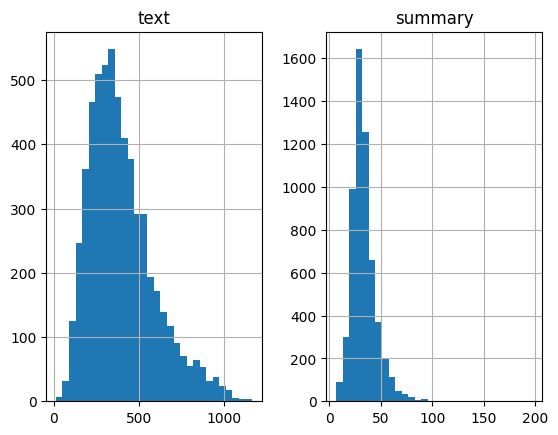

In [ ]:
text_word_count = []
summary_word_count = []

text_word_count = [len(i.split()) for i in lines['Text']]
summary_word_count = [len(i.split()) for i in lines['Summarization']]

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

**Check the best maximum length of text**

In [ ]:
cnt_t, cnt_s = 0, 0
cnt_t = sum(1 for line in lines['Text'] if len(line.split()) <= 800)
cnt_s = sum(1 for line in lines['Summarization'] if len(line.split()) <= 55)
print(cnt_t/len(lines['Text']), cnt_s/len(lines['Summarization']))

0.9536666086047727 0.949660337920223


**Splitting data for training and validation**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(lines['Text'], lines['Summarization'],
                                                      test_size=0.2, random_state=0, shuffle=True)

In [ ]:
X_test = lines_test['Text']
y_test = lines_test['Summarization']

In [ ]:
max_len_text=800
max_len_summary=55

**This code is useful for understanding the distribution of words in a dataset and determining how many rare words there are and their impact on the overall text**

In [ ]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in X_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
text_max_features = total_count - count
print('Text Vocab: ', text_max_features)

% of rare words in vocabulary:  65.90889249733732
Total Coverage of rare words:  3.982110182335169
Text Vocab:  19525


In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in y_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
summary_max_features = total_count-count
print('Summary Vocab: ', summary_max_features)

% of rare words in vocabulary:  70.89582695643301
Total Coverage of rare words:  13.092155221090755
Summary Vocab:  5705


**Preparing text data for input into the model. It uses Tokenizer and pad_sequences methods to convert text into numerical representations that can be fed into a model**

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(text_max_features)
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train    =   x_tokenizer.texts_to_sequences(X_train)
X_valid   =   x_tokenizer.texts_to_sequences(X_valid)

#padding zero upto maximum length
X_train    =   pad_sequences(X_train,  maxlen=max_len_text, padding='post')
X_valid   =   pad_sequences(X_valid, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) + 1

In [ ]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer(summary_max_features)
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train   =   y_tokenizer.texts_to_sequences(y_train)
y_valid   =   y_tokenizer.texts_to_sequences(y_valid)

#padding zero upto maximum length
y_train   =   pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_valid   =   pad_sequences(y_valid, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) + 1

In [ ]:
embeding_index = {}
embed_dim = 100
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float16')
        embeding_index[word] = coefs

In [ ]:
x_embed = np.zeros((x_voc_size, embed_dim))
for word, i in x_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < x_voc_size and vec is not None:
        x_embed[i] = vec

In [ ]:
y_embed = np.zeros((y_voc_size, embed_dim))
for word, i in y_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < y_voc_size and vec is not None:
        y_embed[i] = vec

**Building the keras model**

In [ ]:
from keras import backend as K
import tensorflow as tf
K.clear_session()
latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, embed_dim, weights=[x_embed], trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output1, state_h1_f, state_c1_f , state_h1_b, state_c1_b = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output2, state_h2_f, state_c2_f, state_h2_b, state_c2_b = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs, state_h_f, state_c_f, state_h_b, state_c_b = encoder_lstm3(encoder_output2)
state_h=Concatenate()([state_h1_f,state_h1_b])
state_c=Concatenate()([state_c1_f,state_c1_b])

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, embed_dim, weights=[y_embed],trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
decoder_outputs,stated_h1_f, stated_c1_f , stated_h1_b, stated_c1_b = decoder_lstm(dec_emb,initial_state=[state_h_f, state_c_f, state_h_b, state_c_b])

#decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
#decoder_outputs, stated_h, stated_c = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
stated_h=Concatenate()([stated_h1_f,stated_h1_b])
stated_c=Concatenate()([stated_c1_f,stated_c1_b])

#Attention Layer
attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=16, key_dim=128)
attention_outputs = attention_layer(decoder_outputs, encoder_outputs, encoder_outputs)

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_outputs])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 800)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 800, 100)       │      5,727,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 800, 256),     │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │ (None, 128), (None,    │                │                        │
│                           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ [(None, 800, 256),     │        394,240 │ bidirectional[0][0]    │
│ (Bidirectional)           │ (None, 128), (None,    │                │                        │
│                           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │      1,960,300 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ [(None, 800, 256),     │        394,240 │ bidirectional_1[0][0]  │
│ (Bidirectional)           │ (None, 128), (None,    │                │                        │
│                           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ [(None, None, 256),    │        234,496 │ embedding_1[0][0],     │
│ (Bidirectional)           │ (None, 128), (None,    │                │ bidirectional_2[0][1], │
│                           │ 128), (None, 128),     │                │ bidirectional_2[0][2], │
│                           │ (None, 128)]           │                │ bidirectional_2[0][3], │
│                           │                        │                │ bidirectional_2[0][4]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 256)      │      2,103,552 │ bidirectional_3[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_2[0][0], │
│                           │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ bidirectional_3[0][0], │
│ (Concatenate)             │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 19603)    │     10,056,339 │ concat_layer[0][0]     │
│ (TimeDistributed)    

 Total params: 21,105,063 (80.51 MB)

 Trainable params: 21,105,063 (80.51 MB)

 Non-trainable params: 0 (0.00 B)

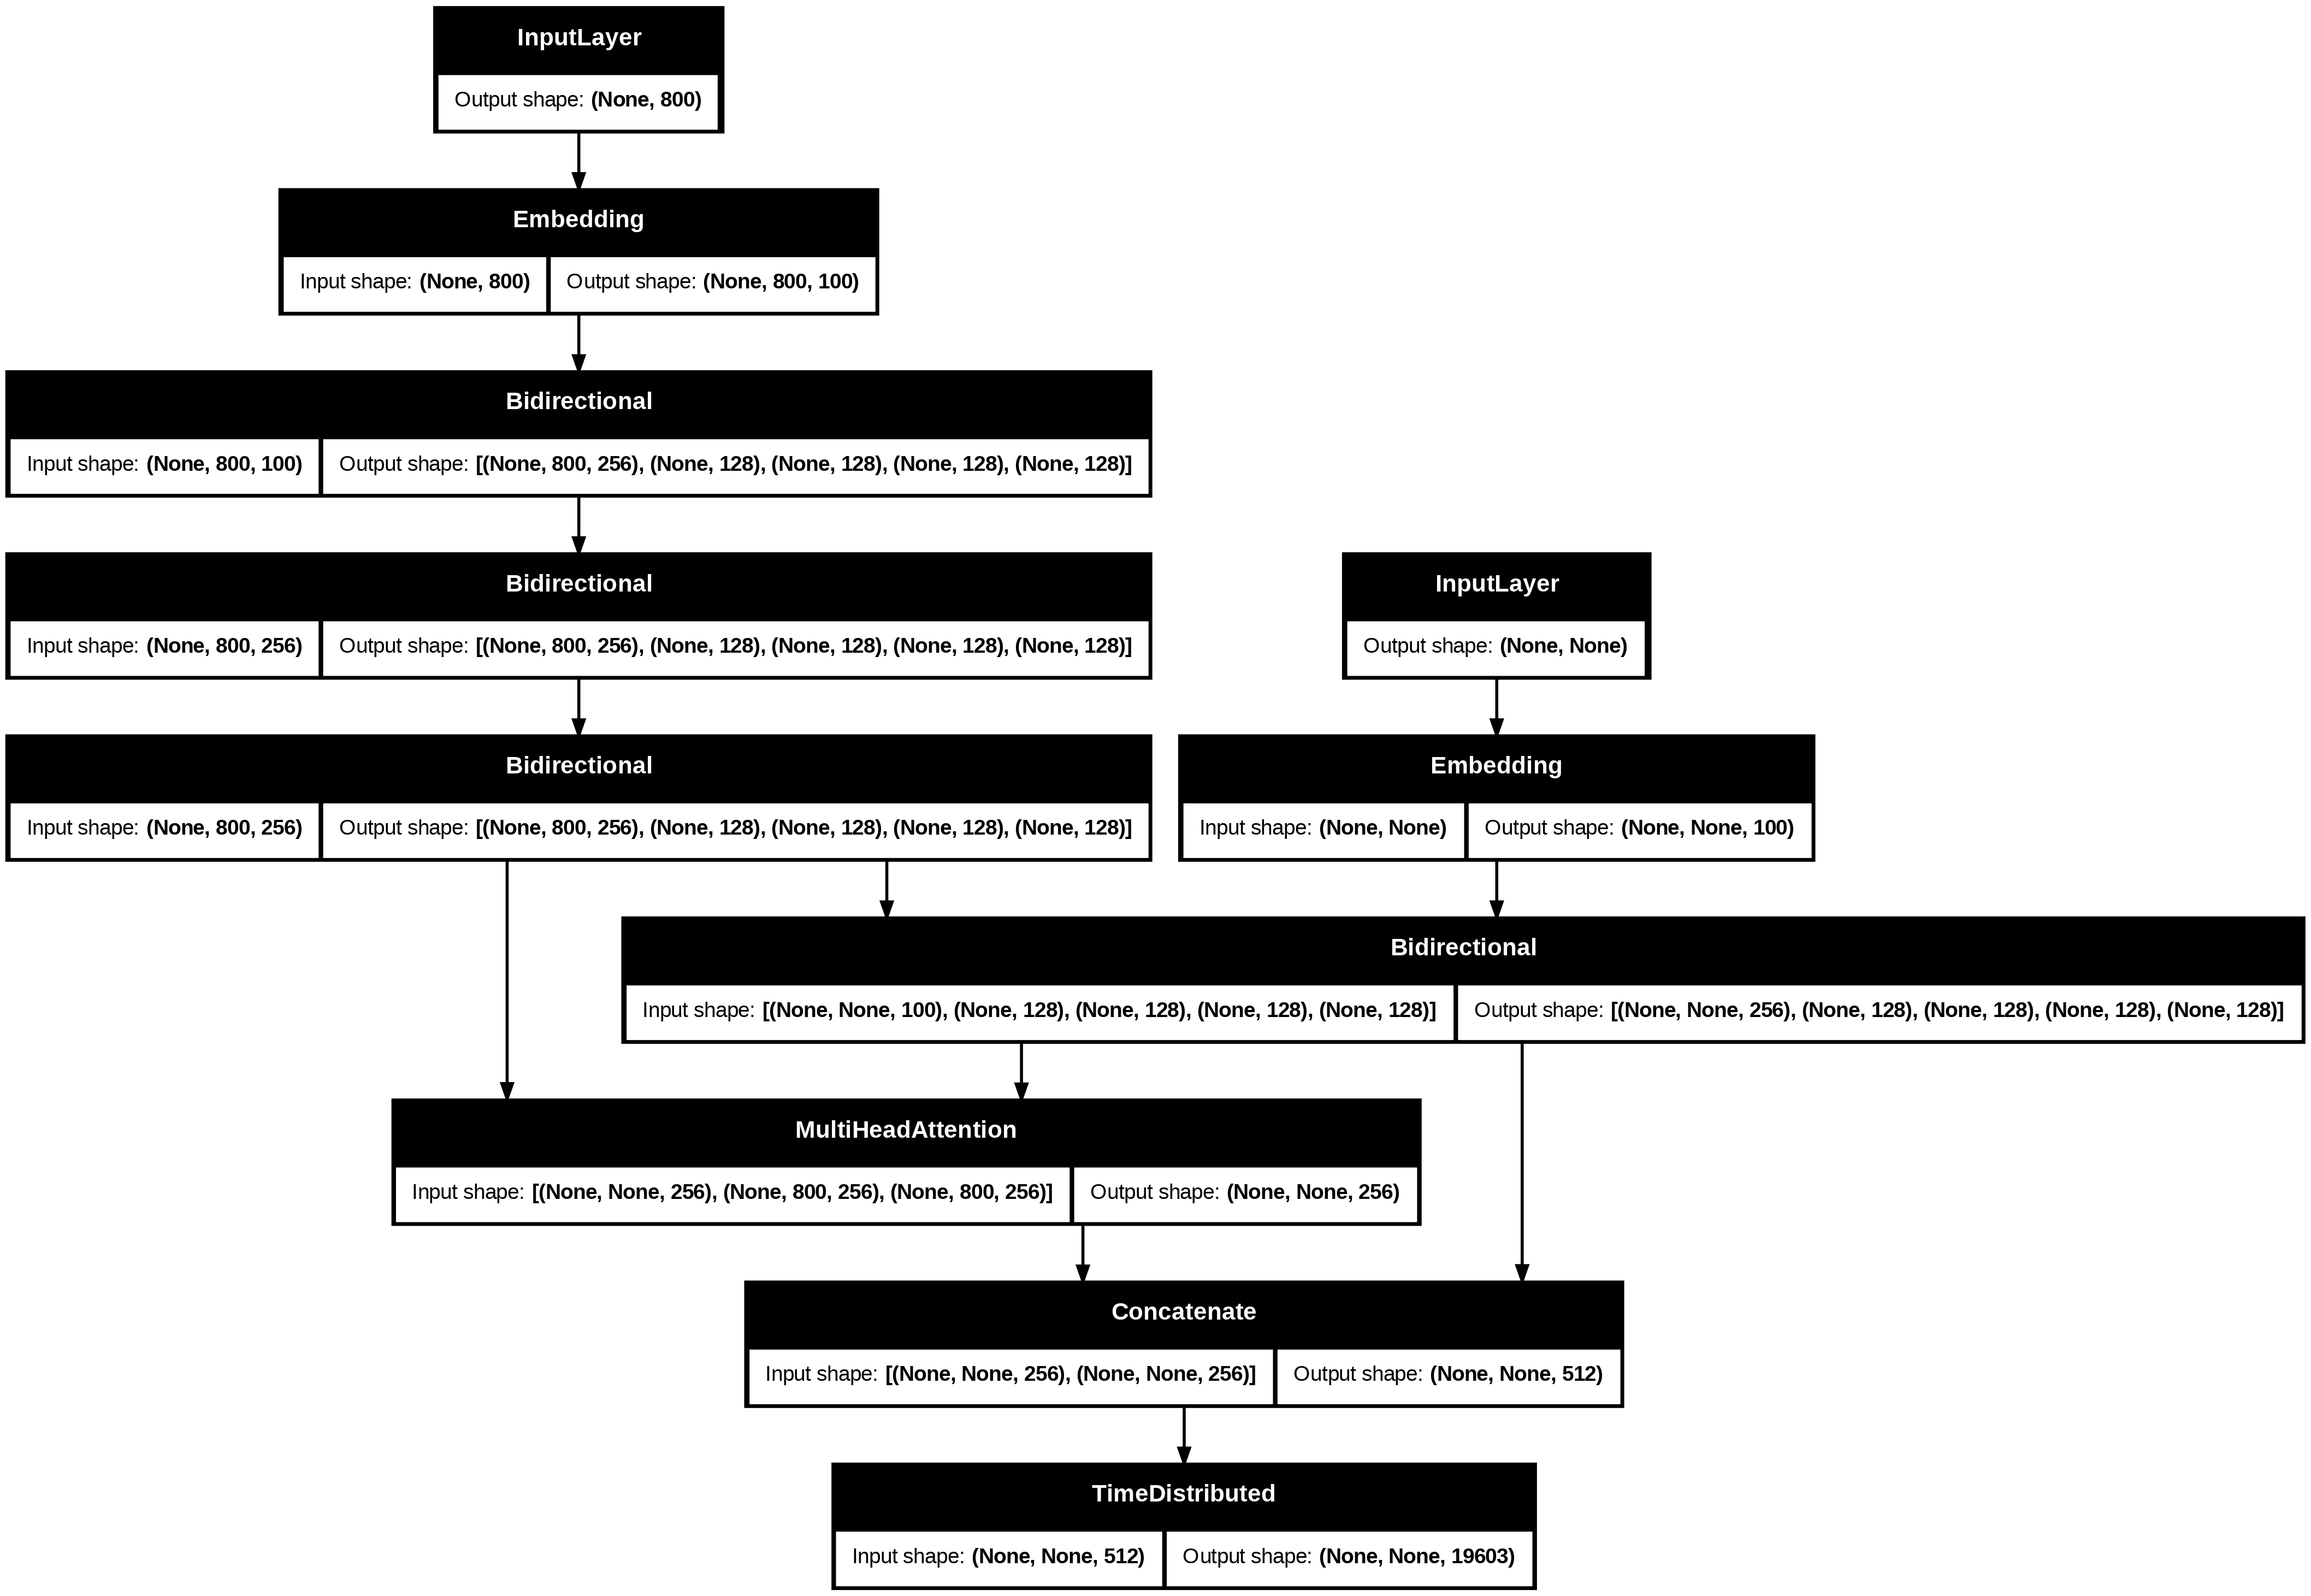

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
                   epochs=10, callbacks=[es], batch_size=128, verbose=1,
                   validation_data=([X_valid, y_valid[:,:-1]], y_valid.reshape(y_valid.shape[0],y_valid.shape[1], 1)[:,1:]))

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1118s 30s/step - accuracy: 0.3974 - loss: 9.2781 - val_accuracy: 0.4994 - val_loss: 4.9591
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1094s 30s/step - accuracy: 0.4856 - loss: 4.6930 - val_accuracy: 0.4994 - val_loss: 4.1664
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1094s 30s/step - accuracy: 0.4848 - loss: 4.2417 - val_accuracy: 0.4994 - val_loss: 3.9668
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1095s 30s/step - accuracy: 0.4846 - loss: 4.0861 - val_accuracy: 0.5006 - val_loss: 3.8638
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1091s 30s/step - accuracy: 0.4892 - loss: 3.9763 - val_accuracy: 0.5071 - val_loss: 3.8097
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1093s 30s/step - accuracy: 0.4904 - loss: 3.9595 - val_accuracy: 0.5143 - val_loss: 3.7877
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1094s 30s/step - accuracy: 0.5012 - loss: 3.9115 - val_accuracy: 0.5245 - val_loss: 3.7699
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1110s 31s/step - accuracy: 0.5052 - loss: 3.9283 - val_accu

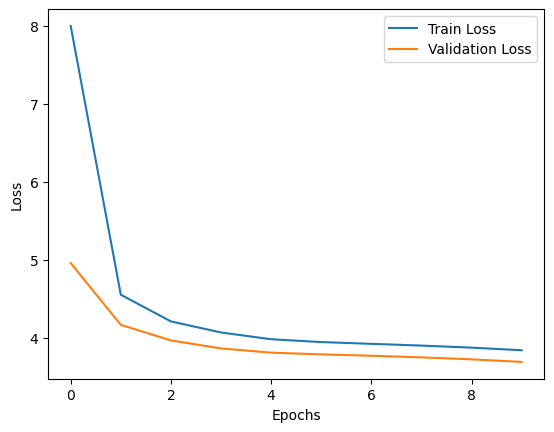

In [ ]:
from matplotlib import pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels for the axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()


In [ ]:
model.save('cnn_text_summarization.keras')

**Inference model for a seq2seq model**

In [ ]:
enc_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h_f, state_c_f, state_h_b, state_c_b])

# Define the decoder inputs for inference (hidden states and cell states from the encoder)
decoder_state_input_h   = Input(shape=(latent_dim,))
decoder_state_input_c   = Input(shape=(latent_dim,))
decoder_state_input_h_b = Input(shape=(latent_dim,))
decoder_state_input_c_b = Input(shape=(latent_dim,))

encoder_output_input = Input(shape=(max_len_text, latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict one time step at a time, we use the decoder LSTM again
decoder_outputs2, stated_h1_f, stated_c1_f, stated_h1_b, stated_c1_b = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c, decoder_state_input_h_b, decoder_state_input_c_b])

# Apply attention
attention_outputs_inf = attention_layer(decoder_outputs2, encoder_output_input, encoder_output_input)

# Concatenate attention outputs and decoder LSTM output
decoder_concat_input2 = Concatenate(axis=-1)([decoder_outputs2, attention_outputs_inf])

# Dense softmax layer to generate prob dist. over target vocab
decoder_outputs2 = decoder_dense(decoder_concat_input2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c, decoder_state_input_h_b, decoder_state_input_c_b, encoder_output_input],
    [decoder_outputs2] + [stated_h1_f, stated_c1_f, stated_h1_b, stated_c1_b]
)

**Save the keras model and tokenizer**

In [ ]:
import pickle

# Save encoder model
enc_model.save('encoder_model.keras')

# Save decoder model
decoder_model.save('decoder_model.keras')

# Save tokenizer
with open('x_tokenizer.pkl', 'wb') as f:
    pickle.dump(x_tokenizer, f)

# Save tokenizer
with open('y_tokenizer.pkl', 'wb') as f:
    pickle.dump(y_tokenizer, f)

In [ ]:
def temperature_sampling_decode_sequence(input_seq, temperature=0.7, max_len_summary=55):
    # Load the tokenizer
    with open('y_tokenizer.pkl', 'rb') as f:
        y_tokenizer = pickle.load(f)

    with open('x_tokenizer.pkl', 'rb') as f:
        x_tokenizer = pickle.load(f)

    # Load the model
    enc_model = tf.keras.models.load_model('encoder_model.keras')
    dec_model = tf.keras.models.load_model('decoder_model.keras')

    reverse_target_word_index = y_tokenizer.index_word
    reverse_source_word_index = x_tokenizer.index_word
    target_word_index = y_tokenizer.word_index

    # Tokenize the input text
    input_seq = x_tokenizer.texts_to_sequences([input_seq])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=800, padding='post')

    # Encode the input sequence to get the initial states
    encoder_output, h_f, c_f, h_b, c_b = enc_model.predict(input_seq)

    # Generate empty target sequence of length 1 (containing only the start token)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    decoded_sentence = ''
    stop_condition = False
    states_value = [h_f, c_f, h_b, c_b]

    while not stop_condition:
        # Predict the next token's probability distribution
        output_tokens, h_f, c_f, h_b, c_b = dec_model.predict([target_seq] + states_value + [encoder_output])

        # Apply temperature scaling
        logits = output_tokens[0, -1, :] / temperature
        exp_logits = np.exp(logits - np.max(logits))  # for numerical stability
        probs = exp_logits / np.sum(exp_logits)

        # Sample the next token based on the modified probabilities
        sampled_token_index = np.random.choice(len(probs), p=probs)
        sampled_char = reverse_target_word_index[sampled_token_index]

        decoded_sentence += ' ' + sampled_char

        # Exit condition: <eos> token or maximum length
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= max_len_summary-1):
            stop_condition = True

        # Update the target sequence and states for the next timestep
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h_f, c_f, h_b, c_b]

    return decoded_sentence.strip()

In [ ]:
for i in range(1,5):
    print("Review:",lines_test['Text'][i])
    print("Original summary:",lines_test['Summarization'][i])
    print("Predicted summary:",temperature_sampling_decode_sequence(lines_test['Text'][i]))
    print("\n")

Review: every weekend sportsmail tally match ratings hand team reporters bring barclays premier league team day eden hazard lead way weekend power chelsea vital narrow win manchester unite hunt premier league title join two team mat jose mourinho champion elect craig gardner star tony pulis west bromwich albion side give win return crystal palace even despite efforts form palace winger yannick bolasie everton claim win struggle burnley stoke city saw southampton leonardo ulloa score continue leicester city late surge swansea city goalkeeper tom heaton 7 5 everton vs burnley burnley might lose goodison park goalkeeper tom heaton way blame produce string save keep everton one goal narrow defeat performance top penalty save ross barkley show bode well burnley hop great escape tom heaton produce string save everton save ross barkley penalty defence seamus coleman 7 5 everton vs burnley seamus coleman key everton win burnley lay goal game kevin mirallas help keep clean sheet coleman foul as

In [ ]:
gen = []
org = []
for i in range(1, 10):
    org.append(lines_test['Summarization'][i])
    gen.append(temperature_sampling_decode_sequence(lines_test['Text'][i]))
    print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for i in range(1, 9):
  print(lines_test['Text'][i+1])
  print(org[i])
  print(gen[i])
  score = sentence_bleu(org[i], gen[i])
  print(score)

durham north carolina cnn president obama nomination loretta lynch become country first african american woman attorney general historic pick confirmation however take new historical relevance wait confirmation vote full senate drag sixth month period senate judiciary committee vote confirm full senate vote lynch case schedule last longer attorney general nominee recent history time senate return easter recess monday longer eight previous nominees job combine lynch currently attorney eastern district new york clear committee february 26 vote 12 8 republican sens orrin hatch utah lindsey graham south carolina jeff flake arizona join democrats send nomination full senate obama nominate lynch replace attorney general eric holder november 8 holder announce plan leave post weeks earlier hundreds miles washington longtime residents durham north carolina beam pride lynch family move city child parent marry 60 years still live watch announcement television encourage know fight hand say lynch f